In [50]:
import os
import re
import json
import random 
import time

from datetime import datetime
from typing import Literal

from bs4 import BeautifulSoup
import unicodedata
import numpy as np
import pandas as pd 

from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.document_loaders import RecursiveUrlLoader
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_mistralai import ChatMistralAI
from langgraph.graph import END, StateGraph, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver

from mistralai import Mistral

from apps.rag_system.rag_pipeline import FinanceMultiAgentRAG

from dotenv import load_dotenv
from tqdm import tqdm



load_dotenv('./.env')

True

## Проверяем RAG пайплайн по методу `Response vs input` 

### P.S. В качестве судьи будет `ministral-8b-latest`

In [14]:
api_key = os.environ.get("MISTRAL_KEY")

FAISS_DB = "D:\programming\ITMO\IntroLLM\FinanceInsight\dataset\index_finance_insight"

EMBEDDING_MODEL_NAME = 'intfloat/multilingual-e5-small'

In [26]:
embedding_model = HuggingFaceEmbeddings(
    model_name = EMBEDDING_MODEL_NAME,
    multi_process = True,
    encode_kwargs = {"normalize_embeddings": True}
)

vector_store = FAISS.load_local(
    FAISS_DB, 
    embedding_model, 
    allow_dangerous_deserialization = True
)

In [18]:
pipeline = FinanceMultiAgentRAG(
    api_key = api_key
)

judge = Mistral(
    api_key = api_key
)

In [59]:
with open('questions_for_metrics.json', 'r', encoding="utf-8") as file:
    questions = json.load(file)

questions

{'0': "Какие моральные дилеммы сталкиваются герои в фильме 'Сделка'?",
 '1': 'Какие операции по карте считаются бесплатными, если оплачиваете покупку кредиткой?',
 '2': 'What strategies could a monopolist employ to maintain its market dominance in the face of a new competitor charging 10% less?',
 '3': 'Какое наказание предусмотрено за искусственное создание доказательств обвинения?',
 '4': 'What are some examples of how market forces have been insufficient to eliminate discrimination against specific groups, despite economic incentives?',
 '5': 'Какое наказание предусмотрено за распространение ложной информации о угрозах безопасности граждан?',
 '6': 'Какие документы необходимо предоставить для постановки на учет по месту пребывания лиц без гражданства, не осуществляющих трудовую или иную не запрещенную законодательством Российской Федерации деятельность?',
 '7': "What is the formula for estimating the value of a firm's stock using the price/earnings ratio?",
 '8': 'What specific disc

In [61]:
questions['1']

'Какие операции по карте считаются бесплатными, если оплачиваете покупку кредиткой?'

In [63]:
output = pipeline.get_response(questions['1'])
output

"Оплата покупок кредитной картой считается бесплатной операцией. Банк не возьмет за это комиссию.\n\nИсточник: {'Course theme': 'Что такое кредитная карта и зачем она вам', 'source': 'tinkoff'}"

In [68]:
answers = {
    "questions" :[],
    "answers" : [],
    "match criteria" : []
}

for q in tqdm(questions.values()):
    # Получаем ответ от RAG пайплайна
    output = pipeline.get_response(q)

    # Получаем ответ от проверяющего
    promt = f""" 
    Оцени правильность ответа на вопрос по шкале от 0 до 1. Где 1 - ответ полностью соответствует вопросу, 0.5 - ответ не полностью раскрывает вопрос и 0 - ответ не соответствует вопросу. 
    Ответ должен быть выдан в формате JSON.
    {{
        "match criteria": ... 
    }}

    Вопрос: {q}
    Ответ: {output}
    """

    messages = [
        {
            "role": "system",
            "content": "Ты бот который определяет правильность ответа на вопрос.",            
        },
        {
            "role": "user",
            "content": promt
        },
    ]

    time.sleep(5)
    chat_response = judge.chat.complete(
        model = "ministral-8b-latest",
        messages = messages,
        response_format = {
            "type": "json_object",
        },
        temperature = 0.5
    )
    
    answers["questions"].append(q)
    answers["answers"].append(output)
    answers["match criteria"].append(eval(chat_response.choices[0].message.content)["match criteria"])
    time.sleep(5)

100%|██████████| 100/100 [33:48<00:00, 20.28s/it]


In [69]:
answers_df = pd.DataFrame(answers)
answers_df

,questions,answers,match criteria
0,Какие моральные дилеммы сталкиваются герои в ф...,Я не знаю ответа на данный вопрос.,0.0
1,"Какие операции по карте считаются бесплатными,...",Оплата покупок по кредитной карте считается бе...,0.8
2,What strategies could a monopolist employ to m...,To maintain its market dominance in the face o...,0.9
3,Какое наказание предусмотрено за искусственное...,За искусственное создание доказательств обвине...,1.0
4,What are some examples of how market forces ha...,One example provided in the text is the persis...,0.8
...,...,...,...
95,How does the combination of underwriting and r...,The combination of underwriting and research i...,0.8
96,How can the government effectively incentivize...,The government can effectively incentivize flu...,0.8
97,What are some specific public policies that ha...,Я не знаю ответа на данный вопрос.,0.0
98,What is the predicted monthly revenue for the ...,The predicted monthly revenue for the Fortune ...,0.5


<Axes: >

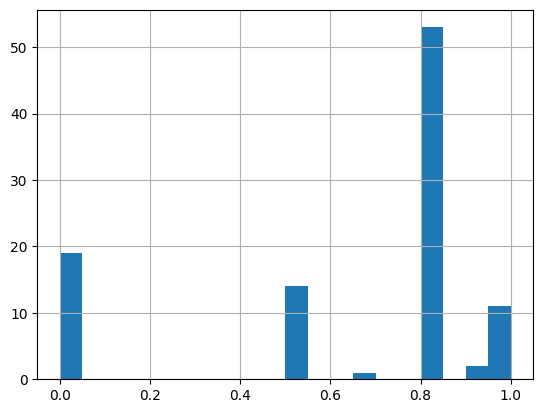

In [78]:
answers_df["match criteria"].hist(bins = 20)

In [72]:
answers_df.head(5)

,questions,answers,match criteria
0,Какие моральные дилеммы сталкиваются герои в ф...,Я не знаю ответа на данный вопрос.,0.0
1,"Какие операции по карте считаются бесплатными,...",Оплата покупок по кредитной карте считается бе...,0.8
2,What strategies could a monopolist employ to m...,To maintain its market dominance in the face o...,0.9
3,Какое наказание предусмотрено за искусственное...,За искусственное создание доказательств обвине...,1.0
4,What are some examples of how market forces ha...,One example provided in the text is the persis...,0.8


In [70]:
answers_df.to_csv("metrics_response_vs_input.csv", index=False)

In [71]:
answers_df["match criteria"].mean()

0.6289999999999999

### Определяем документы для тестирования

In [37]:
documents = vector_store.docstore.__dict__["_dict"]
documents = [documents[index].page_content for index in documents]
documents[:5]

['**Figure 1.1 Finance is the linchpin that connects and directs many parts of a business or organization. (credit: modification of work**\n“Finance behind the Glass” by Max London/flickr, CC BY 2.0)',
 'By the end of this section, you will be able to:',
 'Finance is the study of the management, movement, and raising of money. The word finance can be used as a\nverb, such as when the First National Bank agrees to finance your home mortgage loan. It can also be used as\na noun referring to an entire industry. At its essence, the study of finance is about understanding the uses and\ndecision makers.',
 'Finance is divided into three primary areas in the domestic market: business finance, investments, and\nfinancial markets and institutions (see Figure 1.2). We look at each here in turn.\n**Figure 1.2 The Three Basic Areas of Study in Finance**\n**Business Finance**\n**Business finance looks at how managers can apply financial principles to maximize the value of a firm in a**\nrisky envir

In [38]:
documents[0]

'**Figure 1.1 Finance is the linchpin that connects and directs many parts of a business or organization. (credit: modification of work**\n“Finance behind the Glass” by Max London/flickr, CC BY 2.0)'

### Выбираем 100 рандомных документов для тестирования

In [53]:
questions = []

for doc in tqdm(random.sample(documents, 100)):
    promt = f""" 
    Придумай 1 вопрос исходя из контекста ниже. Ответ должен быть выдан в формате JSON.
    {{
        "question": "..."
    }}

    Контекст:
    {doc}
    """

    messages = [
        {
            "role": "system",
            "content": "Ты бот который помогает придумывать вопросы исходя из контекста.",            
        },
        {
            "role": "user",
            "content": promt
        },
    ]

    chat_response = judge.chat.complete(
        model = "ministral-8b-latest",
        messages = messages,
        response_format = {
            "type": "json_object",
        },
        temperature = 0.5
    )

    q = eval(chat_response.choices[0].message.content)

    questions.append(q["question"])
    time.sleep(10)

100%|██████████| 100/100 [17:48<00:00, 10.69s/it]


In [57]:
with open("questions_for_metrics.json", "w", encoding="utf-8") as f:
    json.dump({i:questions[i]  for i in range(len(questions))}, f, ensure_ascii = False)